In [1]:
import librosa
import matplotlib.pyplot as plt
import noisereduce as nr
import soundfile as sf
from scipy import signal, fft
import numpy as np
import pywt
from scipy.signal import savgol_filter
import os

c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## removing car noise

In [2]:
# Load an audio file
audio_path = '../data/gopro-noise-data'
output_path = '..\\output2'
audio_file = 'SR1.wav'
save_result = True
path = os.path.join(audio_path, audio_file)
audio_data, sample_rate = librosa.load(path)

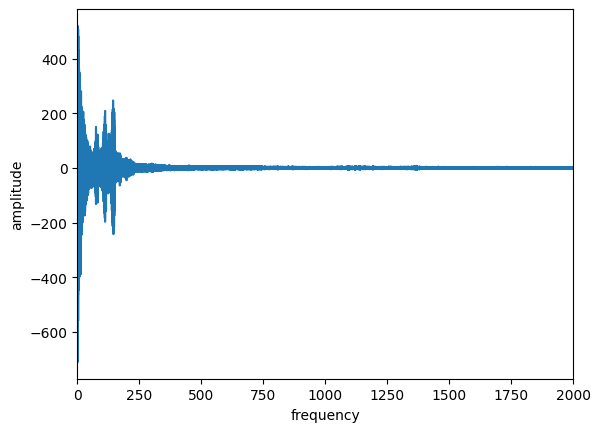

In [4]:
len_data = len(audio_data)

channel_1 = np.zeros(2**(int(np.ceil(np.log2(len_data)))))
channel_1[0:len_data] = audio_data

fourier = fft.fft(channel_1)
w = np.linspace(0, 44000, len(fourier))

# First half is the real component, second half is imaginary
fourier_to_plot = fourier[0:len(fourier)//2]
w = w[0:len(fourier)//2]

plt.figure(1)

plt.plot(w, fourier_to_plot)
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.xlim(0,2000)
plt.show()

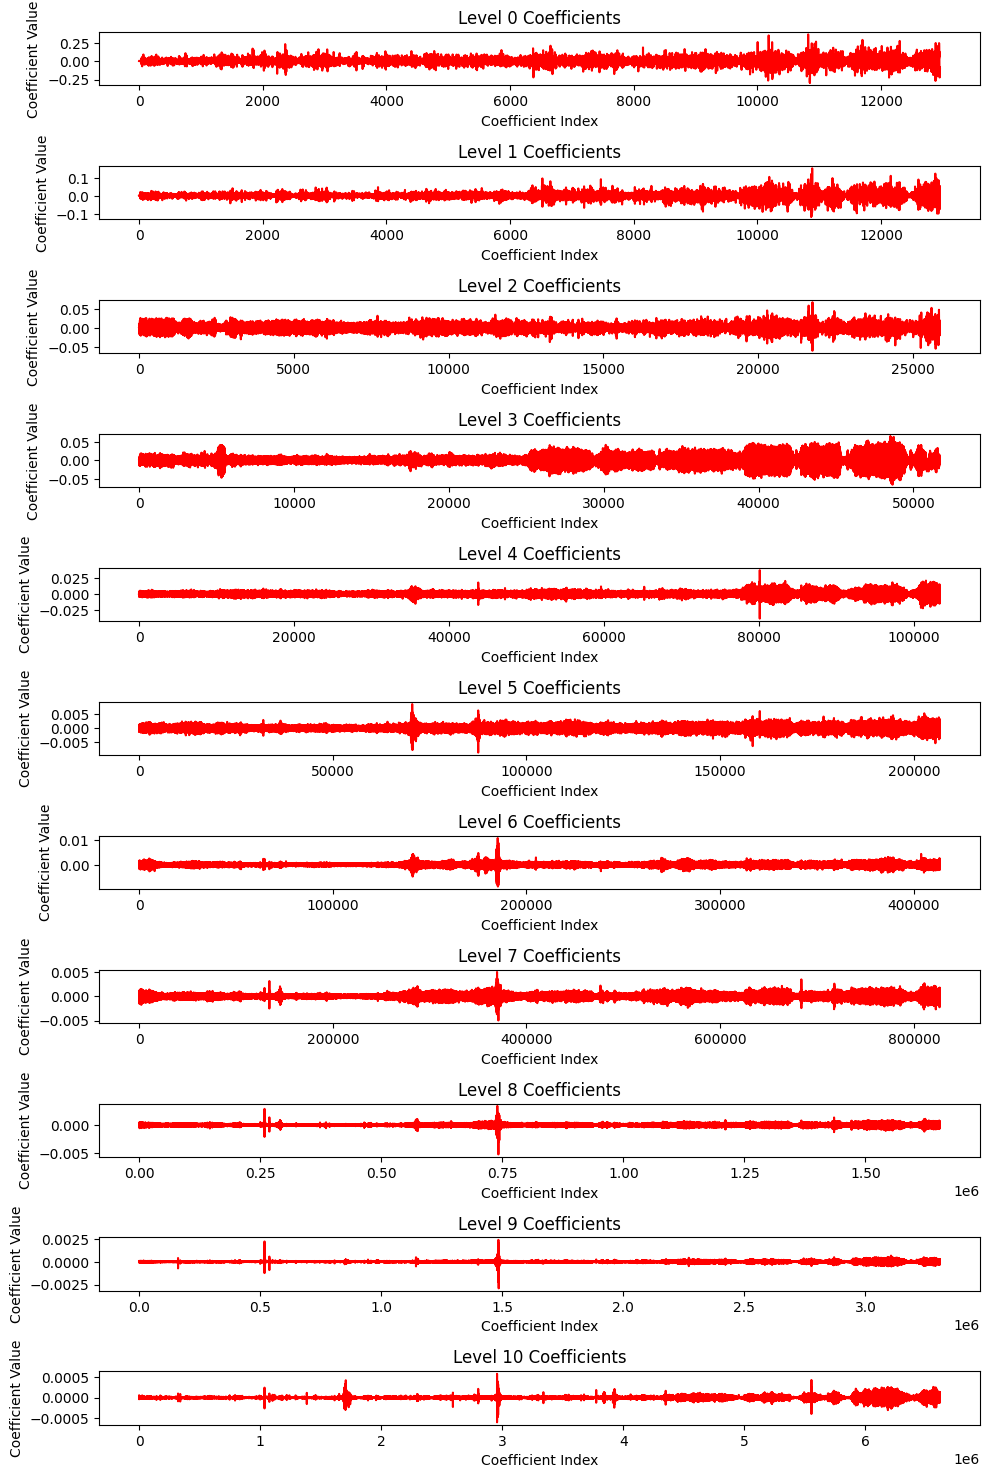

In [46]:
# Define wavelet parameters
wavelet_name = 'db17'  # Choose a wavelet, such as Daubechies 4
level = 10  # Decomposition level

# Perform wavelet transform
coeffs = pywt.wavedec(audio_data, wavelet_name, level=level)

# Plot the wavelet coefficients
plt.figure(figsize=(10, 16))

# Plot wavelet coefficients
for i in range(level):
    plt.subplot(level + 2, 1, i + 2)
    plt.plot(coeffs[i], color='r')
    plt.title(f'Level {i} Coefficients')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Coefficient Value')

# Plot approximation coefficients at the highest level
plt.subplot(level + 2, 1, level + 2)
plt.plot(coeffs[level], color='r')
plt.title(f'Level {level} Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')

plt.tight_layout()
plt.show()

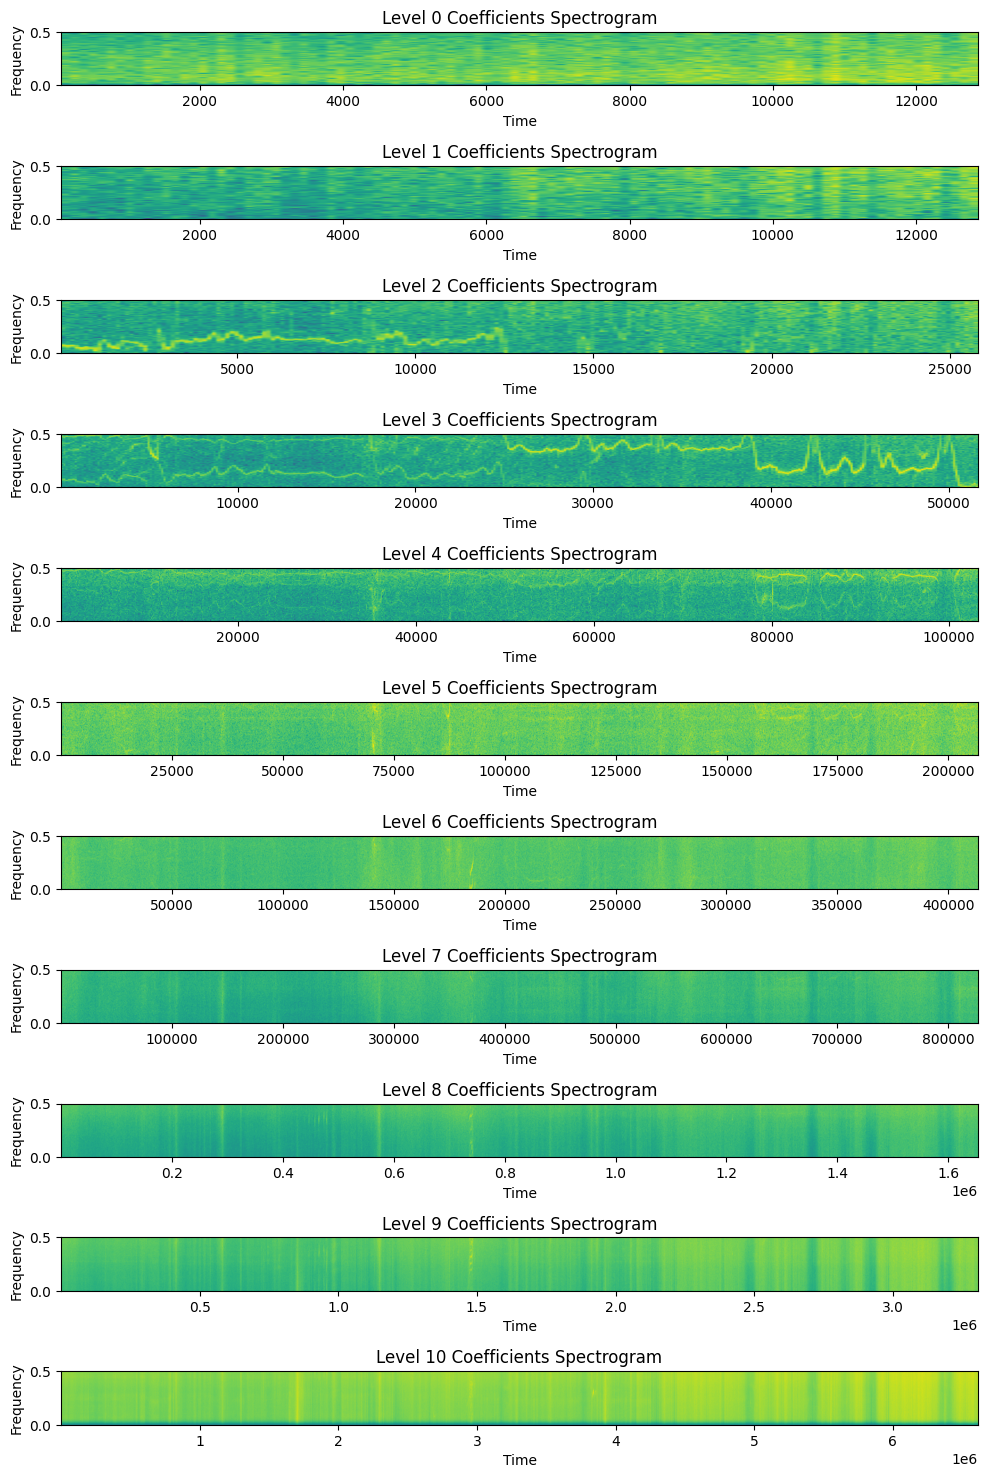

In [47]:
# Plot the spectrogram of wavelet coefficients
plt.figure(figsize=(10, 16))

# Plot spectrogram of wavelet coefficients
for i in range(level):
    plt.subplot(level + 2, 1, i + 2)
    plt.specgram(coeffs[i], Fs=1)
    plt.title(f'Level {i} Coefficients Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Plot spectrogram of approximation coefficients at the highest level
plt.subplot(level + 2, 1, level + 2)
plt.specgram(coeffs[level], Fs=1)
plt.title(f'Level {level} Coefficients Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

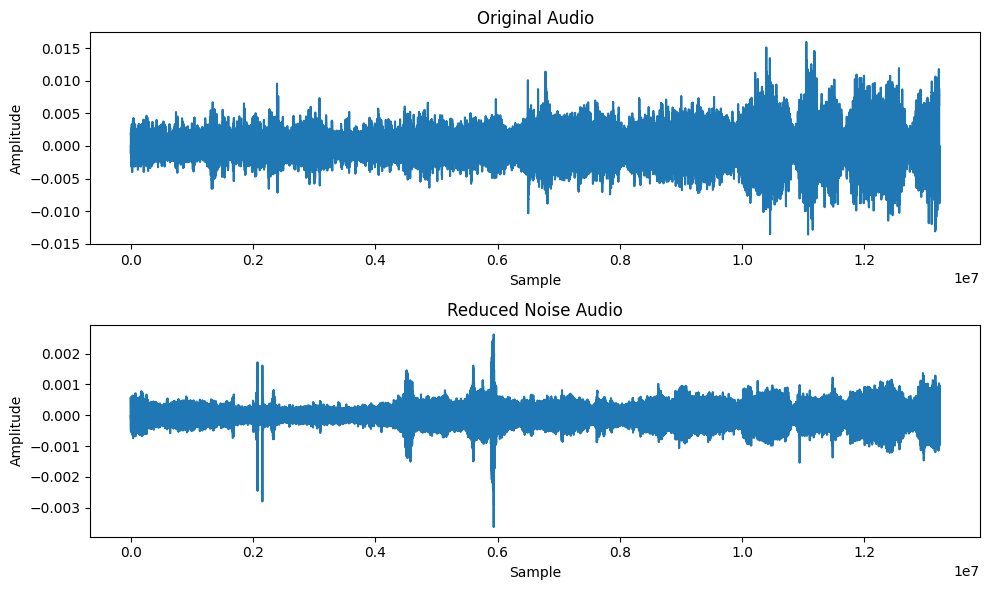

In [48]:
# Apply filtering (attenuate the approximation coefficients)
def filter_wavelets(coeffs, indexes_to_remove: list):
    return [c if (i not in indexes_to_remove) else np.zeros_like(c)
            for i, c in enumerate(coeffs)]

filtered_coeffs = filter_wavelets(coeffs, [0,1,2,3,4])

# Reconstruct signal using inverse wavelet transform
reconstructed_signal = pywt.waverec(filtered_coeffs, wavelet_name)

# Plot original and reduced noise data
plt.figure(figsize=(10, 6))

# Plot original audio
plt.subplot(2, 1, 1)
plt.title('Original Audio')
plt.plot(audio_data)
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# Plot reduced noise audio
plt.subplot(2, 1, 2)
plt.title('Reduced Noise Audio')
plt.plot(reconstructed_signal)
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [49]:
# Save the denoised audio
if save_result:
    new_file_name = f'{audio_file.split('.')[0]}_filtered2.wav'
    sf.write(os.path.join(output_path, new_file_name), 
            reconstructed_signal, sample_rate)

In [50]:
# Save the difference audio
if save_result:
    difference = audio_data - reconstructed_signal
    new_file_name = f'{audio_file.split('.')[0]}_difference2.wav'
    sf.write(os.path.join(output_path, new_file_name),
            difference, sample_rate)